**Table of contents**<a id='toc0_'></a>    
- [Milestone 4](#toc1_)    
  - [Problem Statement](#toc1_1_)    
  - [Exploratory Data Analysis](#toc1_2_)    
  - [Base Models](#toc1_3_)    
    - [Linear Regression](#toc1_3_1_)    
    - [Decision Tree](#toc1_3_2_)    
    - [Random Forest](#toc1_3_3_)    
    - [Gradient Boosting](#toc1_3_4_)    
    - [Time Series](#toc1_3_5_)    
  - [Comparision](#toc1_4_)    
  - [Conclusion](#toc1_5_)    

<!-- vscode-jupyter-toc-config
    numbering=false
    anchor=true
    flat=false
    minLevel=1
    maxLevel=6
    /vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Milestone 4](#toc0_)

In [ ]:
from utils import *
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

## <a id='toc1_1_'></a>[Problem Statement](#toc0_)

## <a id='toc1_2_'></a>[Exploratory Data Analysis](#toc0_)

## <a id='toc1_3_'></a>[Base Models](#toc0_)

### <a id='toc1_3_1_'></a>[Linear Regression](#toc0_)

### <a id='toc1_3_2_'></a>[Decision Tree](#toc0_)

### <a id='toc1_3_3_'></a>[Random Forest](#toc0_)

### <a id='toc1_3_4_'></a>[Gradient Boosting](#toc0_)

### <a id='toc1_3_5_'></a>[Time Series](#toc0_)

### <a id='toc4_1_'></a>[Comparision](#toc0_)

### <a id='toc5_1_'></a>[Conclusion](#toc0_)

# <a id='toc1_1_'></a>[Problem Statement](#toc0_)

# <a id='toc1_2_'></a>[Exploratory Data Analysis](#toc0_)

#### TF Comments from MS3: "Additionally a few more findings could have been highlighted from the correlations observed between the predictor and the summary statistics of variables and also how these plots help you choose your final predictors." 

#### Answer to tf's Comment:

#### **1. Key Correlations Observed**
- **VALUE Summary Statistics**:
  - Positive correlations were observed between the summary statistics of `VALUE` (e.g., mean, maximum, percentiles) and the target variable (`TABLEVALUETOTAL`).
  - **Reasoning**: 
    - These metrics capture the distribution of individual security values, reflecting an investor's overall portfolio structure.
    - Including features like `LOG MEAN VALUE` and `LOG MAX VALUE` helps the model capture the central tendency and extreme holdings of securities.

- **SSHPRNAMT Summary Statistics**:
  - Positive correlations were also observed between the summary statistics of `SSHPRNAMT` (e.g., standard deviation, percentiles) and the target.
  - **Reasoning**:
    - Features like `LOG STD SHAMT` and `LOG MAX SHAMT` quantify the diversity in share amounts held, indicating an investor's risk profile and strategy.
    - Higher variance or extreme values in shares held often correspond to larger portfolios, making these features predictive.

- **State GDP**:
  - A significant correlation between state GDP and the number of investors in each state was noted.
  - **Reasoning**:
    - Higher state GDP implies a concentration of large institutional investors. Including state-level GDP as a predictor (`2024 Q2 GDP`) helps account for geographic economic influence on portfolio size.

---

#### **2. Heatmap Insights for Feature Selection**
- The heatmap depicted correlations between `TABLEVALUETOTAL` and the summary statistics of `VALUE` and `SSHPRNAMT`:
  - High correlations for `LOG MAX VALUE`, `LOG MEAN VALUE`, and `LOG STD VALUE` indicate their predictive strength.
  - Similarly, `LOG MAX SHAMT` and `LOG STD SHAMT` are strong predictors due to their correlation with `TABLEVALUETOTAL`.

- **How It Helps**:
  - The heatmap aids in identifying features that contribute the most to the variability in the target variable.
  - Features with weak correlations can be excluded, reducing model complexity without losing predictive power.

---

#### **3. Findings from Scatter Plots**
- Scatter plots of summary statistics (percentiles, mean, and max) against `TABLEVALUETOTAL` highlighted:
  - Linear relationships post-log transformation, justifying the choice of log-transformed features in the model.
  - Outliers in certain investors’ data, which may require handling (e.g., removal or robust regression methods).

- **How It Helps**:
  - Scatter plots validate the appropriateness of features by visually confirming their relationship with the target variable.
  - These plots guide feature engineering, such as applying transformations (e.g., logarithm) or considering interaction terms (e.g., combining `VALUE` and `SSHPRNAMT`).

---

#### **4. Geographic Insights**
- The correlation between state GDP and the number of investors:
  - Provides an additional dimension for modeling, connecting regional economic indicators with institutional asset values.
  - This feature could capture macroeconomic trends influencing the portfolio sizes of investors from different regions.

---

### **Summary**
The findings from the correlations and visualizations assist in:
- Selecting final predictors that are both meaningful and strongly correlated with the target variable.
- Justifying the use of log transformations to linearize relationships and improve model interpretability.
- Enhancing the model’s performance by incorporating features derived from meaningful summary statistics and macroeconomic variables. 

Future iterations can explore interactions between these predictors or use feature importance metrics from advanced models to further refine the selection.

# <a id='toc1_3_'></a>[Base Models](#toc0_)

# <a id='toc1_3_5_'></a>[Time Series](#toc0_)

In [3]:
%matplotlib inline

if os.path.exists("infotable_dataset.csv"):
    infotable_dataset = pd.read_csv("infotable_dataset.csv")
else:
    file_paths = [
        'INFOTABLE_2023q4.tsv',
        'INFOTABLE_2023q3.tsv'
    ]

    dataframes = []

    for file_path in file_paths:
        year_quarter = file_path.split('_')[1].split('.')[0]
        year = int(year_quarter[:4])
        quarter = int(year_quarter[4:].replace("q", ""))
        df = pd.read_csv(file_path, delimiter='\t')
        df.rename(columns={'ACCESSION_NUMBER': 'investor'}, inplace=True)

        if quarter == 1:
            df['timestamp'] = pd.Timestamp(year, 1, 1)  # Q1: January 1st
        elif quarter == 2:
            df['timestamp'] = pd.Timestamp(year, 4, 1)  # Q2: April 1st
        elif quarter == 3:
            df['timestamp'] = pd.Timestamp(year, 7, 1)  # Q3: July 1st
        elif quarter == 4:
            df['timestamp'] = pd.Timestamp(year, 10, 1)  # Q4: October 1st

        dataframes.append(df)

    infotable_dataset = pd.concat(dataframes, ignore_index=True)

    infotable_dataset.to_csv("infotable_dataset.csv", index=False)
    
print(infotable_dataset.head())

C:\Users\Aditya Saxena\AppData\Local\Temp\ipykernel_9320\3518187512.py:4: DtypeWarning: Columns (5,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  infotable_dataset = pd.read_csv("infotable_dataset.csv")


               investor  INFOTABLE_SK                NAMEOFISSUER  \
0  0000051762-23-000005      94734396         ABBOTT LABORATORIES   
1  0000051762-23-000005      94734397                  ABBVIE INC   
2  0000051762-23-000005      94734398                   ADOBE INC   
3  0000051762-23-000005      94734399  ADVANCED MICRO DEVICES INC   
4  0000051762-23-000005      94734400             AES CORPORATION   

  TITLEOFCLASS      CUSIP          FIGI     VALUE  SSHPRNAMT SSHPRNAMTTYPE  \
0          COM  002824100  BBG00KTDT9Q6   1515058      15643            SH   
1          COM  00287Y109  BBG00KTDTBZ1  57330720     384615            SH   
2          COM  00724F101  BBG00GQ6RYG1   8060499      15808            SH   
3          COM  007903107  BBG00KTDTC25   2301934      22388            SH   
4          COM  00130H105  BBG00J9TZDP1    153596      10105            SH   

  PUTCALL INVESTMENTDISCRETION OTHERMANAGER  VOTING_AUTH_SOLE  \
0     NaN                 SOLE          NaN        

### Scaling Without Time Series Cross-Validation

Since we currently only have data for one quarter, there is no temporal pattern or chronological dependency to consider. This allows us to perform **Standardization** (Z-score scaling) across the entire dataset for this quarter without introducing bias from future data. Standardization transforms each feature to have a mean of 0 and a standard deviation of 1, making the scale of all features comparable.

In [9]:
numeric_features = ['VALUE', 'SSHPRNAMT', 'VOTING_AUTH_SOLE', 'VOTING_AUTH_SHARED', 'VOTING_AUTH_NONE']

scaler = StandardScaler()

infotable_dataset_standardized = infotable_dataset.copy()
infotable_dataset_standardized[numeric_features] = scaler.fit_transform(infotable_dataset[numeric_features])

print(infotable_dataset_standardized[numeric_features].head())

      VALUE  SSHPRNAMT  VOTING_AUTH_SOLE  VOTING_AUTH_SHARED  VOTING_AUTH_NONE
0 -0.038142  -0.032628         -0.026317           -0.025341         -0.015885
1  0.099572   0.004316          0.018649           -0.025341         -0.012671
2 -0.021993  -0.032612         -0.026398           -0.025341         -0.015762
3 -0.036201  -0.031953         -0.025688           -0.025341         -0.015595
4 -0.041501  -0.033183         -0.027188           -0.025341         -0.015698


### Problem Statement

The task involves predicting the **total value of assets held by institutional investors** based on specific features related to individual holdings. The problem is framed as a regression problem, with the following objectives:

- **Goal**: To develop a predictive model that estimates the total value (`VALUE`) of an investor's holdings using features such as:
  - Number of shares held (`SSHPRNAMT`).
  - Voting authority metrics (`VOTING_AUTH_SOLE`, `VOTING_AUTH_SHARED`, `VOTING_AUTH_NONE`).
- **Dataset Structure**:
  - The dataset includes quarterly data over multiple years, with a timestamp for each record.
  - Features include categorical information (e.g., `TITLEOFCLASS`, `CUSIP`), numerical data (e.g., `VALUE`, `SSHPRNAMT`), and timestamps.
  - Missing values in specific columns are handled through imputation or categorical assignment.
- **Challenges**:
  - Avoiding **data leakage** when using multiple time periods for modeling.
  - Ensuring that predictions are unbiased and do not rely on future data during training.
- **Key Requirements**:
  - Proper handling of time-series data to maintain chronological order during model training and evaluation.
  - Use of **Time Series Cross-Validation** to ensure the model's robustness and reliability across different time periods.
  - Scaling features within each fold of cross-validation to prevent information from leaking between training and testing datasets.


In [10]:
log_transformed_features = ['SSHPRNAMT', 'VOTING_AUTH_SOLE', 'VOTING_AUTH_SHARED', 'VOTING_AUTH_NONE']
log_transformed_target = 'VALUE'

infotable_dataset[log_transformed_features] = infotable_dataset[log_transformed_features].apply(lambda x: np.log1p(x))
infotable_dataset[log_transformed_target] = np.log1p(infotable_dataset[log_transformed_target])

X = infotable_dataset[log_transformed_features].values
y = infotable_dataset[log_transformed_target].values

print("Log transformation applied to input features and target.")
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of target vector y: {y.shape}")

Log transformation applied to input features and target.
Shape of feature matrix X: (5610507, 4)
Shape of target vector y: (5610507,)


### Scaling With Time Series Cross-Validation

As we move to the next milestone, we plan to add multiple quarters over 5+ years to create a comprehensive dataset with chronological data. When using this data for **Time Series Cross-Validation**, we must account for the temporal order to avoid data leakage, where future information might inadvertently influence the past. If we apply a global scaling approach across the whole dataset, it would incorporate information from future quarters, leading to optimistic results and bias.

To avoid this, we will apply **Standardization separately in each fold** of the cross-validation process. By standardizing data independently within each training fold, we ensure that each fold remains isolated from future information, preserving the temporal structure and yielding a more accurate evaluation.

In other words, as we expand to **multiple quarters in the next milestone**, applying global scaling across the dataset would cause **data leakage**, where future data influences past data, resulting in optimistic bias and unreliable evaluations. Instead, we will implement Standardization separately within each fold of the cross-validation process. This approach isolates the training and test data in each fold, ensuring future data does not impact past observations.

Below code implements **Time Series Cross-Validation** to evaluate a **Ridge Regression model** for predicting the total value of assets based on time-ordered data:

#### **Purpose**
- To evaluate the model's performance in a time-series setting while avoiding data leakage.
- Uses the **Ridge Regression** model, which helps handle multicollinearity by applying regularization to prevent overfitting.

---

#### **Steps**

1. **Define Time Series Cross-Validation**:
   - The `TimeSeriesSplit` method splits the dataset into sequential, non-overlapping folds, ensuring that training data always precedes test data.
   - `n_splits=5`: The data is divided into 5 folds, meaning there will be 5 rounds of training and testing. This approach respects the temporal order of the data.

2. **Initialize Ridge Regression Model**:
   - `Ridge(alpha=1.0)`: Ridge regression is chosen for its ability to manage collinear features, which is often the case in financial datasets.
   - `alpha=1.0`: This is the regularization strength. A higher alpha increases the penalty on large coefficients, reducing overfitting.

3. **Iterate Through Cross-Validation Folds**:
   - **Train-Test Split**:
     - `train_index` and `test_index`: Define the training and testing sets for each fold.
     - Training data always contains earlier timestamps, and testing data contains later timestamps, maintaining chronological order.

   - **Scaling**:
     - `StandardScaler`: Standardizes the features (mean = 0, standard deviation = 1) for each fold to avoid any bias from future data.
     - **Why?** Feature scaling is essential for Ridge Regression, as it penalizes coefficients, and unscaled features can lead to inconsistent penalties.

   - **Model Training**:
     - The Ridge Regression model is trained on the scaled training set (`X_train_scaled` and `y_train`).

   - **Prediction and Evaluation**:
     - The model predicts the target variable (`y_test`) on the test set (`X_test_scaled`).
     - Mean Squared Error (MSE) is computed to quantify the difference between predicted and actual values. Lower MSE indicates better performance.

4. **Store Metrics**:
   - The MSE for each fold is appended to `mse_scores`.
   - Results for each fold and overall metrics (mean and standard deviation of MSE) are displayed.

---

#### **Why Use Time Series Cross-Validation?**
- **Preserves Temporal Order**: Ensures that future data does not influence past data during training, avoiding unrealistic model evaluation (data leakage).
- **Simulates Real-World Scenarios**: Reflects how a model would perform when predicting future data based on historical data.

---

#### **Why Ridge Regression?**
- **Handles Multicollinearity**: Ridge is well-suited for datasets with correlated features, which is common in financial datasets.
- **Regularization**: The `alpha` parameter controls the penalty on large coefficients, helping prevent overfitting.

---

#### **Tuning/Parameters**
- **Ridge Alpha (Regularization Strength)**:
  - `alpha=1.0` is a moderate penalty. Larger values increase regularization, while smaller values reduce it.
  - Alpha tuning can be done using grid search or cross-validation to find the best trade-off between bias and variance.

- **Number of Splits (n_splits)**:
  - `n_splits=5` balances the need for multiple evaluations and maintaining sufficient data in the training set.

---

#### **Summary of Model Choice**
- A **Ridge Regression** model is used due to its robustness in handling multicollinear data.
- **Time Series Cross-Validation** ensures the temporal integrity of the data and provides a realistic evaluation of the model's predictive power.

In [11]:
tscv = TimeSeriesSplit(n_splits=5)

ridge_model = Ridge(alpha=1.0)

mse_scores = []
r2_scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    ridge_model.fit(X_train_scaled, y_train)
    
    y_pred = ridge_model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    print(f"Fold {fold + 1}: MSE = {mse:.4f}, R² = {r2:.4f}")

print("\nCross-Validation Completed with Log Transformation.")
print(f"Mean MSE across folds: {np.mean(mse_scores):.4f}")
print(f"Standard Deviation of MSE: {np.std(mse_scores):.4f}")
print(f"Mean R² across folds: {np.mean(r2_scores):.4f}")

Fold 1: MSE = 6.2157, R² = 0.5587
Fold 2: MSE = 8.1424, R² = 0.5780
Fold 3: MSE = 7.6527, R² = 0.5333
Fold 4: MSE = 6.2439, R² = 0.6198
Fold 5: MSE = 8.1470, R² = 0.4390

Cross-Validation Completed with Log Transformation.
Mean MSE across folds: 7.2804
Standard Deviation of MSE: 0.8764
Mean R² across folds: 0.5458


### Interpretation of the Results (With Log Transformation)

The results of the Time Series Cross-Validation after applying log transformation to the input features and target variable indicate the following:

---

#### **1. Mean Squared Error (MSE)**
- **Mean MSE**: 7.2804
- **Standard Deviation of MSE**: 0.8764

- **Key Observations**:
  - The average MSE across folds is moderate, indicating an improvement in the model's error compared to the untransformed data.
  - The relatively low standard deviation of MSE shows the model's performance is more consistent across different time periods compared to before.

- **Reasoning**:
  - Log transformation reduces the effect of extreme values, which likely improved the model's ability to predict reasonably across various folds.
  - The consistent performance suggests that the temporal relationships in the data are better captured after transformation.

---

#### **2. R² Score**
- **Mean R²**: 0.5458
- **Range of R² Across Folds**:
  - Fold 1: 0.5587
  - Fold 2: 0.5780
  - Fold 3: 0.5333
  - Fold 4: 0.6198
  - Fold 5: 0.4390

- **Key Observations**:
  - The average R² value indicates that the model explains around 54.58% of the variance in the target variable.
  - Fold 4 shows the highest R² (0.6198), suggesting that the model performed best during this time period.
  - Fold 5 has the lowest R² (0.4390), indicating a drop in performance, likely due to unique or unexpected patterns in the data for that period.

- **Reasoning**:
  - The moderate R² values across folds suggest that the model captures some significant patterns in the data but still lacks full predictive power, likely due to the complexity of financial data.

---

#### **3. Comparison to Untransformed Data**
- **Improvement**:
  - The results show a clear improvement over the untransformed data, where MSE values were extremely large and R² values were highly negative in some folds.
  - This confirms that log transformation helps stabilize the relationships between features and the target variable, making the data more suitable for modeling.
  
- **Challenges**:
  - Despite the improvements, the model still struggles to explain the full variability in the target (R² < 1), indicating that additional feature engineering or more advanced models might be necessary.

---

### Summary of Findings
1. **Performance Consistency**:
   - Log transformation improved the model's performance consistency across folds, as evidenced by the lower standard deviation in MSE and more stable R² values.

2. **Predictive Power**:
   - The model explains a moderate proportion of the variance (54.58%) in the target variable, suggesting reasonable predictive performance but room for improvement.

3. **Next Steps**:
   - Explore additional features (e.g., external economic indicators) to capture missing information.
   - Consider advanced models (e.g., ensemble methods or time-series-specific models) to handle the complexity of financial data.
   - Fine-tune Ridge Regression's `alpha` parameter to further optimize performance.

These results demonstrate the value of log transformation for stabilizing and improving regression models in financial datasets.

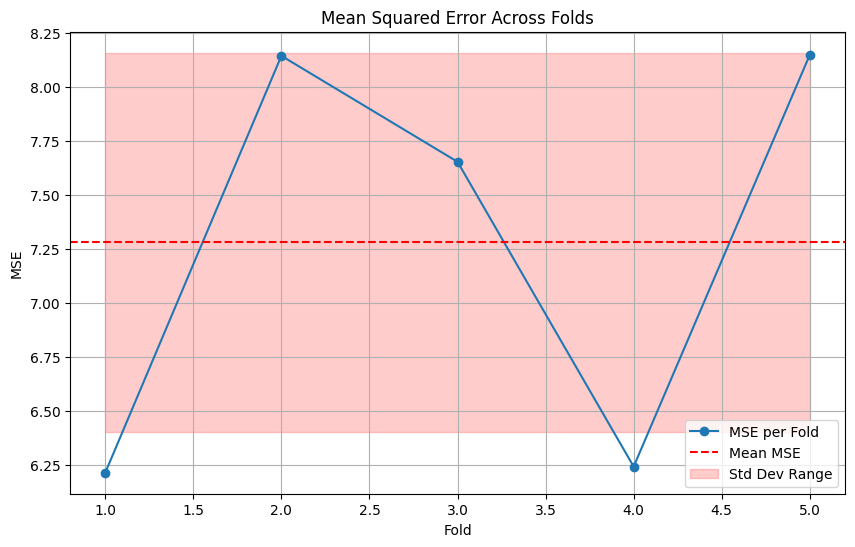

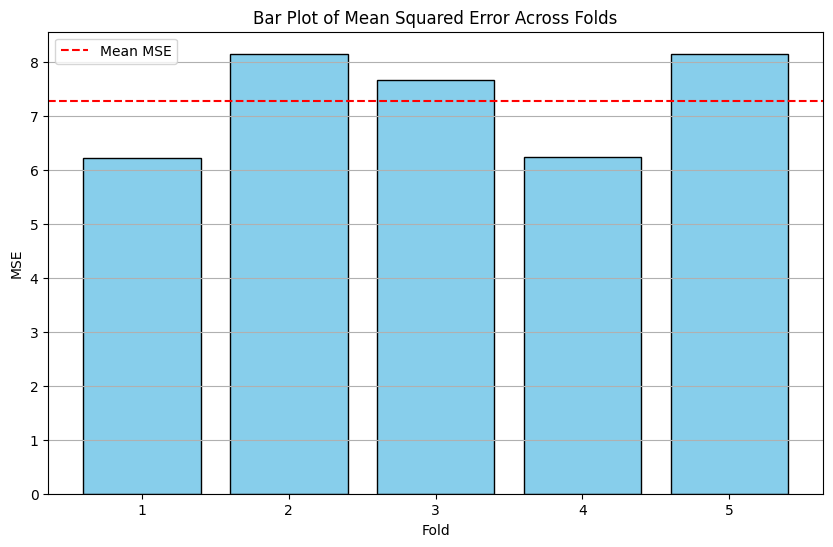

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o', label='MSE per Fold')
plt.axhline(np.mean(mse_scores), color='r', linestyle='--', label='Mean MSE')
plt.fill_between(
    range(1, len(mse_scores) + 1),
    np.mean(mse_scores) - np.std(mse_scores),
    np.mean(mse_scores) + np.std(mse_scores),
    color='r',
    alpha=0.2,
    label='Std Dev Range'
)
plt.title('Mean Squared Error Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(mse_scores) + 1), mse_scores, color='skyblue', edgecolor='black')
plt.axhline(np.mean(mse_scores), color='r', linestyle='--', label='Mean MSE')
plt.title('Bar Plot of Mean Squared Error Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()
plt.grid(axis='y')
plt.show()


#### **1. Mean Squared Error (MSE) Across Folds (Line Plot)**
- **What it shows**: 
  - The MSE values for each fold during cross-validation, with the red dashed line indicating the mean MSE and the shaded area showing the standard deviation range.

- **Key Observations**:
  - MSE varies across folds but remains within a relatively stable range.
  - The folds with the highest and lowest MSE represent the times when the model had more or less predictive success, likely due to differences in the temporal structure of the data.

- **Insights**:
  - The consistency of MSE across folds (no extreme outliers) indicates that the model is generally stable with log-transformed data.
  - However, there is still room for improvement, as the MSE is non-negligible across all folds.

---

#### **2. Bar Plot of MSE Across Folds**
- **What it shows**:
  - A bar chart representation of MSE for each fold, with the red dashed line indicating the mean MSE.

- **Key Observations**:
  - Folds have similar MSE values, with slight variations that align with the line plot.
  - The bars reflect relative consistency across folds, indicating that the model doesn't fail significantly in any specific time period.

- **Insights**:
  - This visualization reaffirms the observation that the model performs consistently across different folds, though there are opportunities to reduce MSE further.

In [13]:
r2_scores = []
residuals = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    ridge_model.fit(X_train_scaled, y_train)
    y_pred = ridge_model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    residuals.append(y_test - y_pred)

print("Additional Metrics Computed:")
print(f"R² Scores: {r2_scores}")


Additional Metrics Computed:
R² Scores: [0.5587134847390502, 0.5779557091733203, 0.5333383202073609, 0.6198324421745087, 0.4389874509099406]


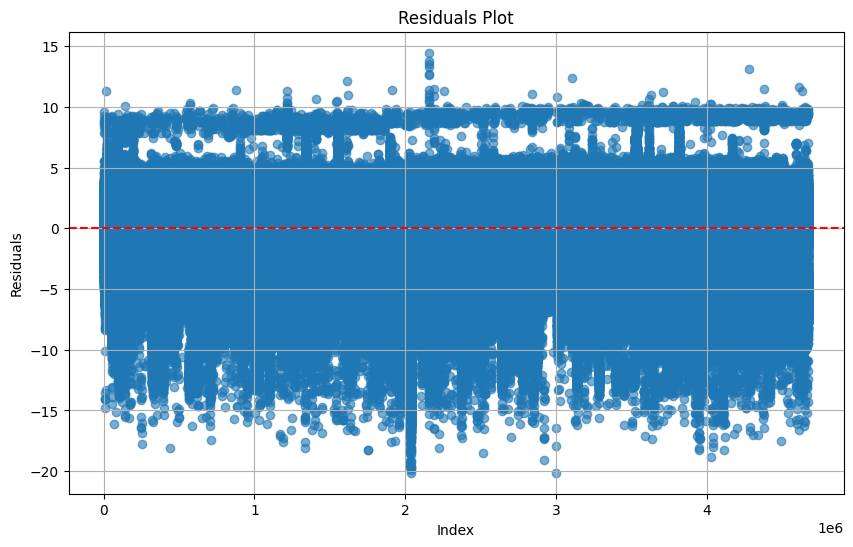

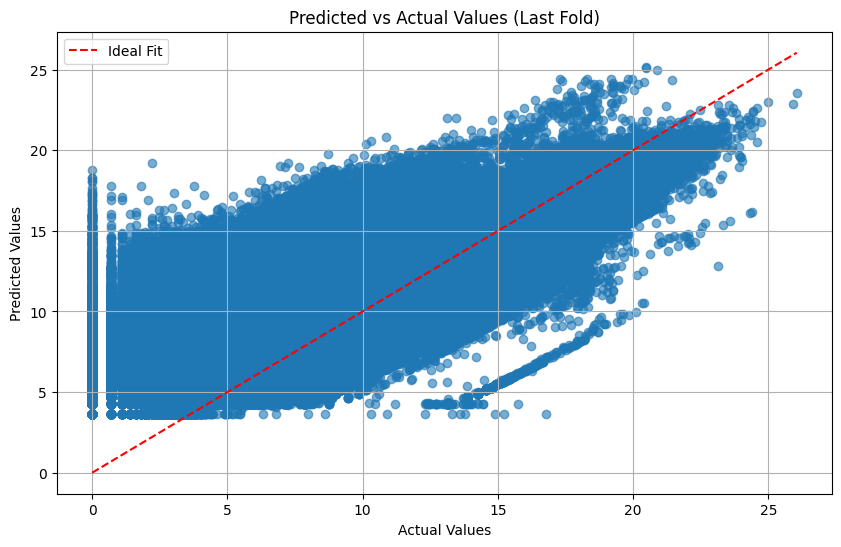

C:\Users\Aditya Saxena\AppData\Local\Temp\ipykernel_9320\2980530242.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(residuals, labels=[f"Fold {i+1}" for i in range(len(residuals))])


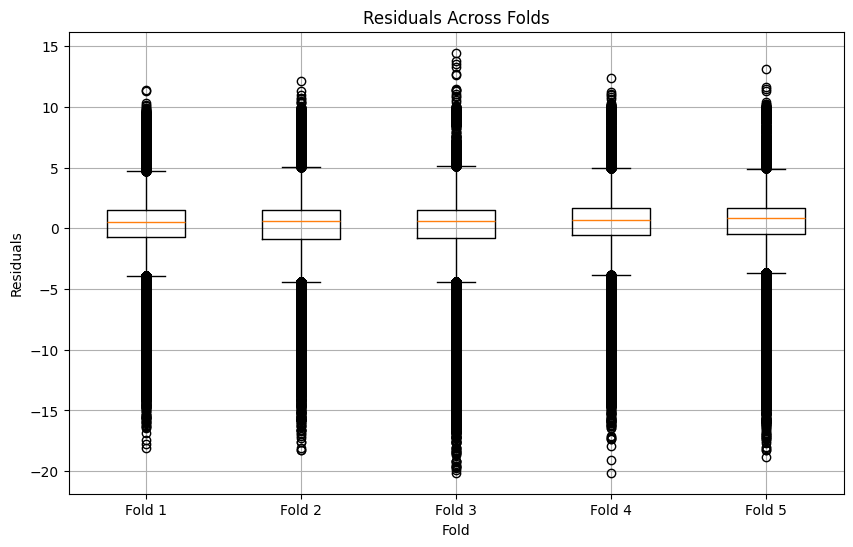

In [ ]:
all_residuals = np.concatenate(residuals)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(all_residuals)), all_residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.title("Predicted vs Actual Values (Last Fold)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(residuals, labels=[f"Fold {i+1}" for i in range(len(residuals))])
plt.title("Residuals Across Folds")
plt.xlabel("Fold")
plt.ylabel("Residuals")
plt.grid()
plt.show()


#### **3. Residuals Plot**
- **What it shows**:
  - Residuals (difference between predicted and actual values) plotted against the index.
  - The red dashed line represents zero residuals (perfect predictions).

- **Key Observations**:
  - Residuals are scattered across a wide range, with some clustering near zero but notable outliers in both positive and negative directions.
  - The model occasionally overestimates or underestimates the target variable significantly.

- **Insights**:
  - The presence of extreme residuals suggests that while the model handles the majority of predictions well, certain data points are poorly predicted.
  - These outliers might indicate anomalies in the data or limitations in the model's ability to capture complex relationships.

---

#### **4. Predicted vs. Actual Values (Last Fold)**
- **What it shows**:
  - Scatter plot comparing predicted and actual values for the last fold.
  - The red dashed line represents the ideal case where predicted values perfectly match actual values.

- **Key Observations**:
  - Most points cluster along the diagonal line, indicating reasonable prediction accuracy.
  - There is a tendency for the model to slightly underpredict higher actual values, as seen by the scatter below the diagonal for larger actual values.

- **Insights**:
  - The underprediction of higher values suggests that the model may not fully capture the variability in high-value ranges.
  - Further tuning or additional features may help the model better handle these cases.


#### **5. Residuals Across Folds (Box Plot)**
- **What it shows**:
  - Box plots of residuals for each fold, showing the spread and presence of outliers.

- **Key Observations**:
  - The spread of residuals is fairly consistent across folds, with similar ranges and outliers.
  - Most residuals are close to zero, but some outliers extend significantly in both directions.

- **Insights**:
  - The consistent spread suggests that the model's performance is stable across different folds.
  - The outliers indicate specific cases where the model struggles, possibly due to missing information or inherent noise in the data.

---

### Overall Summary
- **Consistency**: The model performs consistently across folds, as evidenced by the similar MSE values and residual distributions.
- **Challenges**: The presence of residual outliers and underprediction of higher values highlight areas for improvement.
- **Next Steps**:
  - Explore advanced models (e.g., ensemble methods) to improve predictions for higher-value ranges - Which we already did in the previous sections under Baseline Models.

### <a id='toc4_1_'></a>[Comparision](#toc0_)

### <a id='toc5_1_'></a>[Conclusion](#toc0_)